# Multi-label classification for PASCAL VOC 2009 image dataset

# 1 Introduction

In this notebook, we will explore a different way of learning features: deep learning. For this purpose we will utilize the Keras library. We will tackle multi-label classification. The PASCAL VOC dataset will be used to train the classifiers throughout the tutorial. For the problem above, we will train the classifiers from scratch and experiment with transfer learning. Towards the end we will also try to exploit the weaknesses of deep learners by means of adversarial examples. Different approaches and alternative techniques will be mainly discussed throughout the tutorial. However, the last section of the tutorial will be reserved in order to reflect on what we have achieved and to analyze both the results and the shortcomings.

# 2 Dataset

We will use the [PASCAL VOC-2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset for this tutorial. This dataset consists of images of 20 different classes as well as their labels. We will download a slightly reorganized version of this dataset. You can find the structure in the following subsections.

## Fetch data

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
import numpy as np
import random
import os
import collections
from numpy import zeros
import numpy as np
import scipy 
import cv2 
import sys
from skimage import io
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import ImageDataGenerator 

In [22]:
!gdown https://drive.google.com/uc?id=1tZ4WZOEwFSK4-pOVOh8MzFzV-yrL5DB_
!tar -xf pascalvoc2009.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1tZ4WZOEwFSK4-pOVOh8MzFzV-yrL5DB_
To: /content/pascalvoc2009.tar.gz
901MB [00:03, 293MB/s]


## General overview

The dataset is structured as follows:

![alt text](https://i.imgur.com/wafsfg0.png)



**Images**

The Images folder contains ALL image files (so training, test and validation images are mixed; their actual labels are found in different folders).

**Segmentation**

The Segmentation part consists of two folders: SegmentationImage and DetectedObjects. SegmentationImage contains images where the different segments are indicated.

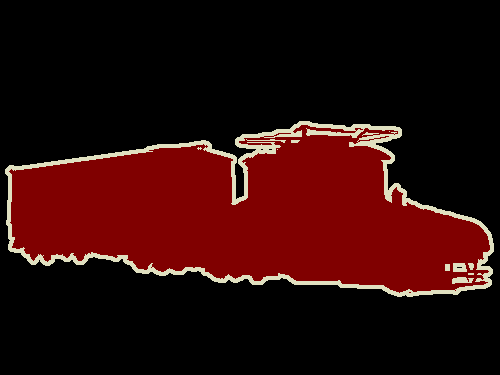

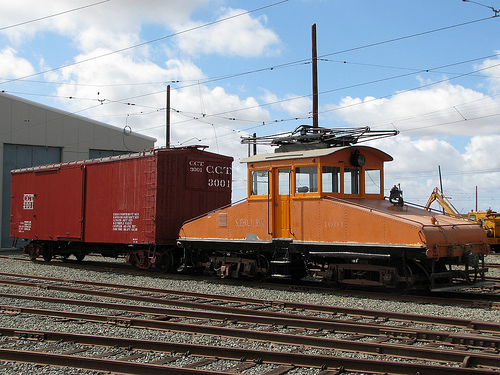

In [3]:
im_segmentation_file = os.path.join("Segmentation","SegmentationImage","2009_005287.png")
im_original_file = os.path.join("Images","2009_005287.jpg")

im_segmentation = cv2.imread(im_segmentation_file)
im_original = cv2.imread(im_original_file)

cv2_imshow(im_segmentation)
cv2_imshow(im_original)

**DetectedObjects** contains a description of objects in an image. Each file corresponds to one image, and each line in this file corresponds to one object.  Note that this folder is divided into training, testing and validation. For example:

In [4]:
im_detected_objects = os.path.join("Segmentation","DetectedObjects","Training","2009_005287.txt")
with open(im_detected_objects) as file:
  lines = file.readlines()
  for line in lines:
    print(line)

train 9 496 124 294



The contents of these files formatted as: `object xmin xmax ymin ymax`. So we detected a train in the rectangle from (9, 124) to (496, 294).

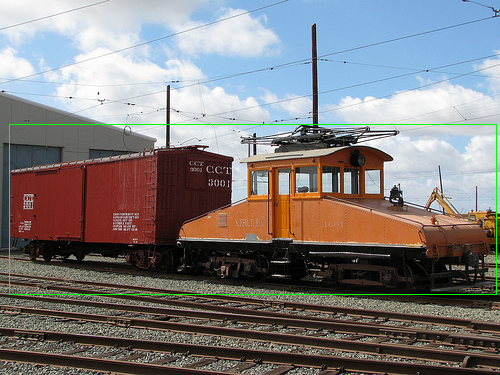

In [5]:
im_ = cv2.rectangle(np.copy(im_original),(9,124),(496,294),(0,255,0))
cv2_imshow(im_)

To facilitate this, use the following function.

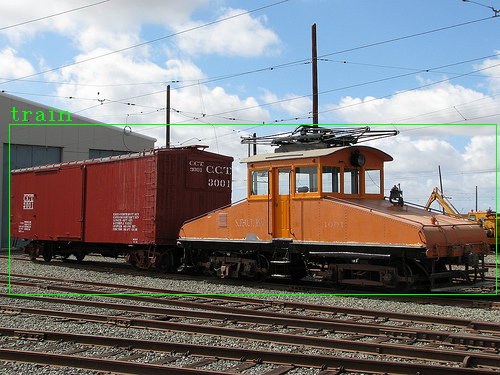

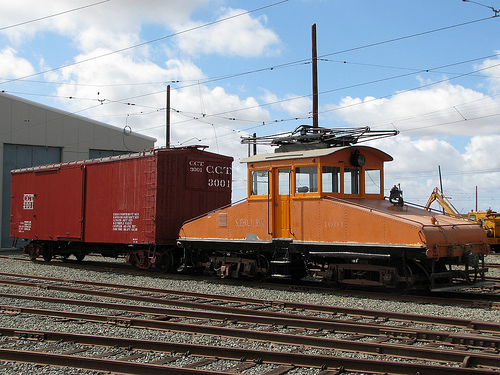

In [6]:
'''
Indicates a part of an image, and adds the label
@param imgIn          input image
@param description    string, line read from file (object xmin xmax ymin ymax)
'''
def annotate(imgIn,description):
  line = description.split(" ")
  obj = line[0]
  xmin = int(line[1])
  xmax = int(line[2])
  ymin = int(line[3])
  ymax = int(line[4])
  img = np.copy(imgIn)
  img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,255,0))
  img = cv2.putText(img,obj,(xmin,ymin-4),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(0,255,0))
  return img

cv2_imshow(annotate(im_original,line))
cv2_imshow(im_original)

# 3 Classification

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing import image  
from keras.layers import Activation, MaxPooling2D, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator

## Multi-label classification from scratch

In this section we will build and train a deep neural network classifier from scratch in order to classify multi-labeled instances in our dataset. Multi-label classification is a different problem than binary or multi-class classification in that it requires our classifier to detect multiple classes within an image that are not mutually exclusive. 

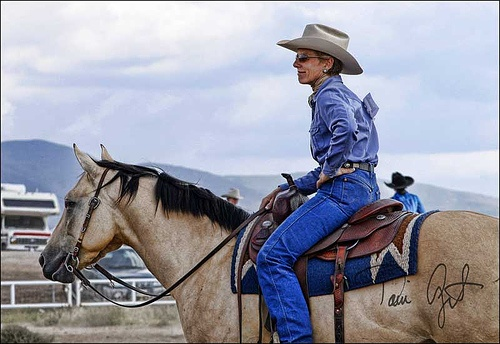

In [8]:
filename = "2007_006364"
img = cv2.imread(os.path.join("Images",filename+".jpg"))
cv2_imshow(img)

Take the image above for example. It consists of a horse, a person, and even a couple of vehicles in the back that are less obvious. Our classifier will then attempt to detect these classes in a binary way meaning that it will not count the instances of a specific class but only decide whether it occurs or does not occur in the image. Emphasis on 'attempt' because the classifier might not always succeed. In some instances it will even detect classes that were not originally labeled because of human error. 


This already seems like a much harder problem than binary or multi-class classification. You will quickly learn that it will inherently become harder when we dive into the dataset. As in the image above, some classes despite being in the image, are not entirely in the full image or blocked by other classes (occlusion). The goal is to generalize each class in our dataset and to learn the features that define the class in a general way. This is in contrast with hand-engineered features that will only focus on certain defined features such as specific types of edges or corners. In this way, the classifier will be able to detect our classes despite the object of interest not fully present in the image or just generally hard to point out due to various reasons commonly encountered in computer vision. 

For this task, we will not work with a standard feed forward neural network which is applicable for most machine learning problems, but a Convolutional Neural Network. This is a network that is specifically engineered to efficiently learn the many patterns and structures in images with as few parameters as possible. This will be discussed in a later section. 

### Data 

#### Loading multi-labels

Let us take a look at the images and their labels in the dataset that is provided to us. In the directory `Classification` there are three text files namely `labels_train.txt`, `labels_validation.txt`, `labels_test.txt` with each one containing the image filenames and labels of the training, validation and test set respectively. 

In [9]:
os.listdir("Classification")

['labels_validation.txt', 'labels_test.txt', 'labels_train.txt']

Looking into one of the text files we can see that it consists of lines of text. Each line consists of the filename of a certain image and its label. However, since we are dealing with a multi-label problem, there can be multiple lines of a certain image containing different labels. 

In [10]:
with open(os.path.join("Classification","labels_train.txt")) as file:
  lines = file.readlines()[0:5]
  for line in lines:
    print(line)

2008_000002 tvmonitor

2008_000003 person

2008_000003 train

2008_000007 boat

2008_000008 horse



We can confirm above that the file `2008_000003` contains both a person and a train. The filenames refer to the JPG file that actually is contained within the `Images` directory. 

Our first task is to build a datastructure that contains each unique image and its set of labels. A dictionary can be used for this purpose. The following code reads each text file (training, validation and test) in the `Classification` directory. It will split each line of the file into the file name and label and sets the former as key and the latter as value in the dictionary. This dictionary does not contain the image yet, only its filename and an array of labels as we can verify in the output. 

In [11]:
# this will contain a set of unique class names present in our dataset
labels = set()

def collect_data(file_name):

  dictionary = collections.defaultdict(list)

  with open(os.path.join("Classification",file_name)) as file:
      for line in file.readlines():
        im_path, label = line.split(" ")
        
        # we ignore faulty labels or imagenames
        if label != '\n' and im_path != "":
          if '\n' in label:
            # split file names and labels
            label = label[0:len(label)-1]
            labels.add(label)
            # key = filename, value = array of labels
            dictionary[im_path].append(label)
  return dictionary


# collecting the filenames and labels into a dictionary
training_data = collect_data('labels_train.txt')
testing_data = collect_data('labels_test.txt')
validation_data = collect_data('labels_validation.txt')

# validating their lengths
print('Size training data:', len(training_data))
print('Size validation data:', len(validation_data))
print('Size testing data:', len(testing_data), '\n')

# first few keys of the dictionary of the training set
print('Portion of the contents of training data dictionary:\n')
c = 0
for i, (file_name, lbl) in enumerate(training_data.items()):
  print(file_name, lbl)
  if c == 10:
    break
  c+=1

Size training data: 5013
Size validation data: 1030
Size testing data: 1011 

Portion of the contents of training data dictionary:

2008_000002 ['tvmonitor']
2008_000003 ['person', 'train']
2008_000007 ['boat']
2008_000008 ['horse', 'person']
2008_000009 ['cow']
2008_000015 ['bottle']
2008_000016 ['tvmonitor']
2008_000019 ['dog']
2008_000021 ['aeroplane']
2008_000023 ['bottle', 'person', 'tvmonitor']
2008_000026 ['dog', 'person']


#### Analyzing data

In the previous code we also collected each class in a set `labels`. We will turn this into a dictionary of classes and their numeric index (ordered alphabetically). This will be useful in a later section. Below you can confirm each unique class that our dataset contains and which we will eventually try to predict. 

In [12]:
class_dictionary = dict()
class_dictionary_inv = dict()

for i, label in enumerate(sorted(labels)):
  class_dictionary[i] = label
  class_dictionary_inv[label] = i

class_dictionary_inv

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In order to get a sense of what kind of labels the dataset contains, we will plot each unique occurence of the labels. The reason why this is important is because our dataset must consist of a **balanced** amount of the instances that we are trying to predict. We want our classifier to not focus too much on a specific class but rather "see" a balanced proportion of each class. The reason for this is because the parameters that the neural network will learn depends on each instance that it processes. It will be punished based on the amount of labels that it labels incorrectly (or rewarded if done correctly). If our dataset contains too much of a certain class, the neural network will outsmart us (through no fault of its own) and try to predict that certain class very well such that it can show us that it is doing a good job. Obviously, we want the network to perform well on ALL instances. We must also take our learning setup into account which is **Batch Gradient Descent**. We will discuss this later, but what it means is that we learn the network in small amount of batches (say 32). When our dataset is shuffled randomly before the training process, each batch will (hopefully) contain a variety of images and their respective classes. Multiple classes because we are dealing with a multi-label environment. If our dataset for example consists of 90% humans and only 10% of the rest of the classes, odds are that the batch will also contain the same proportion of images. This means that our classifier will have "high accuracy" if it predicts humans very well despite predicting all other classes poorly. 

**We can conclude that our majority class will outweigh any other class that we are trying to predict if our dataset is balanced poorly.** 

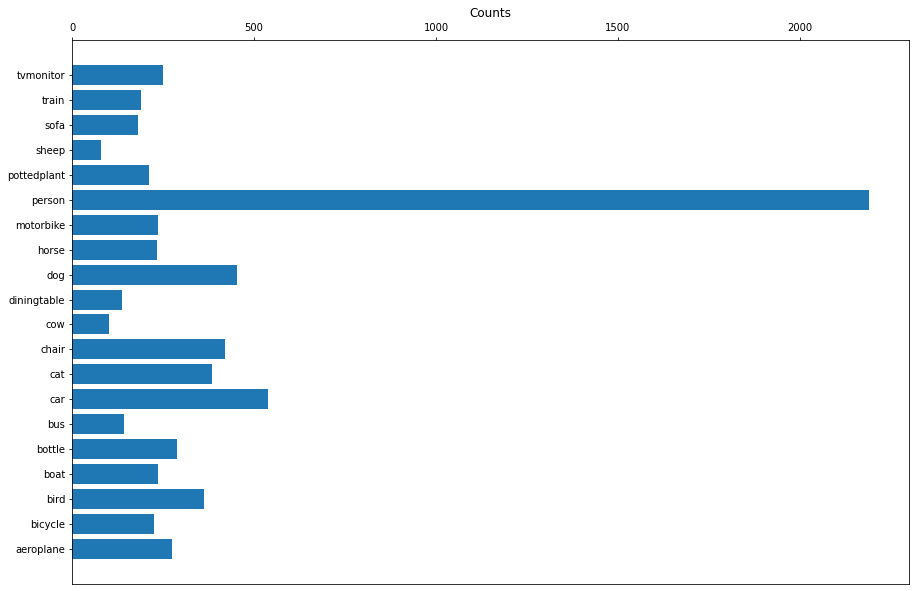

In [13]:
counts = np.zeros(20)

for i, (img, lbls) in enumerate(training_data.items()):
  for j, label in enumerate(lbls):
    index = class_dictionary_inv[label]
    counts[index] += 1

fig, ax = plt.subplots(figsize=(15, 10))
ax.barh(sorted(labels), counts, align='center')
ax.set_title('Counts')
ax.xaxis.tick_top()
plt.show()

The barchart above tells us that our dataset is anything but **balanced**. There are 10 times more instances of people than any other class. In a way, this makes sense because when other classes are photographed, such as bicycles, a person is likely to sit on the bicycle or be near of it. And for a majority of our classes, this seems to be the case when we closely inspect our images.

As previously discussed, this is problematic. However, we cannot expect differently in a multilabeled environment and have to face and solve this problem creatively. Another issue is that the low amount of instances of each class, despite it not being balanced is also problematic. Deep neural networks require a lot of samples to converge. Depending on the problem we are trying to solve and the architecture of the network, this can be hundreds of thousands if not multimillion instances. We have merely a total of +- 5000 instances for the purpose of training, and both 1000 instances for validating and testing our classifier. We could solve this by **upsampling**. However, given that we do not have a large amount of data, we would end up resampling the same instance multiple times. This is not helpful when we want our classifier to generalize. We could also perform **undersampling** which is to remove a portion of the majority class. If we tried undersampling images that contain people, we could end up removing images of classes that are already in minority. And we do not have that kind of luxury in this dataset. Another technique that is known to work is to assign **weights** to the samples. We would thus assign high weights to the under represented classes and low weights to the majority class. But again, we are dealing with a multilabeled environment where there are multiple classes in each image. Rather than to attempt this, we will try to solve it during the learning process, e.g. by assigning weights to each class. We will discuss this later. 

#### Collecting images and one-hot encoding

In the previous subsection, we had built a dictionary for the training, validation and test set. Now it is time to actually download the images in memory and to also turn the labels into more meaningful representation for the classifier to understand. One way to do this (although Keras requires it) is to do **onehot encoding**. Onehot encoding is the process of, as the name suggest, turn a symbolic representation of our class into a binary one such that each class is defined with the same unique identifier. Although this seems unnecessary, it will make sense when we look at the output and architecture of our neural network classifier. Normally, we would create an array of zeros with the length being the amount of classes in which a one would mean that a class is present. Since we are dealing with multi-labels, there will be multiple ones in the array depending on the classes present in each image instance. For example, if an image contains an airplane and a tv monitor, then the resulting encoded array would look like:

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In this case 'aeroplane' is the first and 'tv monitor' is the last index to be set to one (assuming the classes are ordered alphabetically). Every other element is set to zero. 


We define several functions that will convert a given dictionary into two arrays. One array starting with `X_` which contains the images and another one starting with `y_` with its respective encoded labeling. Both arrays will have the same ordering. We will also resize all the images to a smaller size such as 64x64. In this way computations won't take as long because our network will have to do less convolutions than for example an image size of 128x128. We could explore techniques such as **progressive resizing** which is to resize the images during training and essentially freeze the layers and retrain. In this way the network will become scale invariant and more robust to image features that are not necessarily the same size/scale as our training instances. However, data augmentation which we will explore later will also work for achieving more generalization. In this case however we will set the  size statically.

In [ ]:
def one_hot(labels):
  encoding = np.zeros(20)
  for i in range(len(labels)):
    index = class_dictionary_inv[labels[i]]
    encoding[index] = 1
  return encoding


def collect_data(dictionary, img_shape=(64,64)):
  images = []
  y = []
  for i, (im_path, tags) in enumerate(dictionary.items()):
    try:
      img = os.path.join("Images",im_path + ".jpg")
      img = cv2.imread(img)
      img = cv2.resize(img, img_shape)
      img = img[...,::-1] # BGR to RGB
    except:
      continue
    images.append(img)
    encoding = one_hot(tags)
    y.append(encoding)
  return images, y

X_train, y_train = collect_data(training_data)
X_val, y_val = collect_data(validation_data)
X_test, y_test = collect_data(testing_data)

# sanity check
print("Size training image set: ", len(X_train))
print("Size training label set: ",len(y_train))
print("Size validation image set: ",len(X_val))
print("Size validation label set: ",len(y_val))
print("Size test image set: ",len(X_test))
print("Size test label set: ",len(y_test))

Size training image set:  5013
Size training label set:  5013
Size validation image set:  1030
Size validation label set:  1030
Size test image set:  1011
Size test label set:  1011


#### Shuffling and normalization

There are three types of sets available to us. One is the training set that will be used to train the classifier with. The validation set is to be used during training to check whether the classifier is able to generalize and is thus not overfitting on the training set. And at last, there is the test set, which is used after training to again check how well your classifier is trained based on the metric you are looking for. Both test and validation set are set up in a way to represent the "real-world" distribution and to test whether our classifier will do well generally speaking. We also shuffle our training data and normalize the channels of each pixel to a smaller number (between 0 and 1). Normalization is a standard preprocessing practice and done such that the network during its learning of weights (in which small corrections are made) will not be thrown off by large fluctuating values that will be encountered in images. Another practice is [standardization](https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/). This will center the pixel values around zero. Both practices will help our network to converge faster. 

In [ ]:
#shuffle
def preprocess_sets(X_train, y_train, X_val, y_val, X_test, y_test, standardize=True):

  random.Random(42).shuffle(X_train)
  random.Random(42).shuffle(y_train)

  print(y_train[0])
  cv2_imshow(cv2.cvtColor(X_train[0], cv2.COLOR_RGB2BGR))
  print(y_train[1])
  cv2_imshow(cv2.cvtColor(X_train[1], cv2.COLOR_RGB2BGR))

  #normalization
  X_train = np.array(X_train, dtype="float") / 255.0
  X_test = np.array(X_test, dtype="float") / 255.0
  X_val = np.array(X_val, dtype="float") / 255.0

  #standardization
  if (standardize):
    X_train_mean = np.mean(X_train, axis=0)
    X_train -= X_train_mean
    X_test -= X_train_mean
    X_val -= X_train_mean

  y_train = np.array(y_train)
  y_test = np.array(y_test)
  y_val = np.array(y_val)

  return X_train, y_train, X_val, y_val, X_test, y_test

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


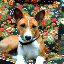

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


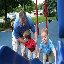

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_sets(X_train, y_train, X_val, y_val, X_test, y_test)

### Metrics and loss function

#### Weighting classes

We promised that we would solve the class imbalance. The loss function that we are going to use for our classifier will calculate the error between the truth instance and predicted one in order to adjust the parameters of the network by means of backpropagation. We will dive deeper in to the specific loss function later. Because our classes are not balanced, our network will not be punished properly for not correctly classifying the minority classes. Our network will essentially propagate its weights in a way such that predicting the majority class correctly will be more rewarding that predicting the minority class correctly. The network will likely converge fast and give the illusion that it has learnt very well (depending on what metric was used). To combat this, we will use class weights. This will limit the size of adjustment during gradient descent for the imbalanced classes and increase weight of under represented classs. While this is trivial in Keras for standard classification problems, it is less so for [multilabel classification](https://github.com/keras-team/keras/issues/2592#issuecomment-387579022). We will compute the weights for each of our classes and implement it in our loss function later. 


In [ ]:
def calculating_class_weights(y_true):
  weights = np.empty([20, 2]) # 20 classes
  for i in range(20):
    weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
  return weights

class_weights = calculating_class_weights(y_train)
class_weights

array([[ 0.52890905,  9.14781022],
       [ 0.5236056 , 11.09070796],
       [ 0.53903226,  6.90495868],
       [ 0.52481156, 10.57594937],
       [ 0.53058848,  8.67301038],
       [ 0.51457606, 17.65140845],
       [ 0.5599866 ,  4.66759777],
       [ 0.54147764,  6.52734375],
       [ 0.54572175,  5.96785714],
       [ 0.51028094, 24.81683168],
       [ 0.513943  , 18.43014706],
       [ 0.54979162,  5.52092511],
       [ 0.52437238, 10.75751073],
       [ 0.52459188, 10.66595745],
       [ 0.88819986,  1.14399817],
       [ 0.52197001, 11.87914692],
       [ 0.50810866, 31.33125   ],
       [ 0.51862197, 13.925     ],
       [ 0.51969728, 13.19210526],
       [ 0.52624396, 10.026     ]])

#### Metrics

In this section we will discuss several metrics and decide which one will be most beneficial during the learning process. We will also describe the loss function that is to be used during training.

##### Accuracy

Will accuracy be a good metric for our problem? In order to answer that question we must know what accuracy stands for in the context of multilabel classification. Accuracy will be the amount of true positives and true negatives divided by the amount of true positives, true negatives, false negatives and false positives. Imagine the following truth label and predicted label. 

y_true: [1, 0, 0, 1, 0, 0, 0, 0, 0]

y_pred: [0, 1, 0, 1, 0, 1, 1, 0, 0] 

In this case we have 1 false negative, 3 false positives, 3 true negatives and only 1 true positive. The accuracy is 67% which is surprisingly high considering that we only predicted one label correctly. In reality, we have 20 classes meaning that the predicted array will be larger and possibly contain even more zeros (because we assume an image to contain small amount of classes). This again will give us the illusion that our classifier is performing well, while it is not. We need a metric that will capture the amount of false positives and false negatives and present it in an intuitive way. 

##### F1-score

In order to capture both false positives (FP) and false negatives (FN), we will use precision and recall respectively. Precision is # TP divided by # TP + # FP. So precision will scale inversely to the amount of false positives. If we have too much false positives, we will attain a low precision score. Recall is the # TP divided by # TP + # FN. 

The problem is that we can still obtain a high precision score while having a low recall score and vice versa. If we virtually have no false positives yet have not many true positives either, we may get high precision. Similarly, if we managed to predict all of our true positives yet have large amount of false positives, we may get high recall. This is why we will use [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). This metric allows an equal contribution of both metrics. The formula is F1 = 2 * P * R / P + R. [Since Keras does not provide these metrics anymore, we must define our own custom one](https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d). 

In [ ]:
def get_f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall + K.epsilon())
  return f1_val

#### Loss function

##### Binary cross entropy

As a loss function, we have chosen for the [Binary Cross Entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/) loss function. The reason for using this loss function is because it implements both the Cross-Entropy loss and Sigmoid function. The former is our baseline formula for calculating the error between the ground truth label and predicted label. The latter is used because it forces each of the output neurons in our network to be an output between 0 and 1, independent of other neurons. This is different than Softmax in that Softmax normalizes the output over all output neurons (over all classes) such that the summed output is equal to one. Sigmoid is very useful because it allows us to create C independent binary classification problems where C is the amount of classes which in our case is 20. This in return allows us to calculate the gradients of the loss function with respect to each class and propagate it back independently. We essentially have a global loss, which is the sum of each (local) loss value over each class. During training, we will monitor the global loss (in mini-batches). The entire pipeline can be [visualized](https://gombru.github.io/assets/cross_entropy_loss/sigmoid_CE_pipeline.png) as follows: 


<img src="https://docs.google.com/uc?export=download&id=1TLQ3x02MI57DR8YnW_RTVe7_ZwfMFniY"  width="600">

Where si is the predicted value and ti is the truth value (between 0 and 1) for class i. Since we are dealing with class imbalance, we must weigh the output of our loss function with the class weights that we had calculated earlier. Because we can not define class weights as we normally would for multiclass classification, we define a [new loss function](https://github.com/keras-team/keras/issues/2592#issuecomment-387579022) instead that combines the weights and Binary Cross Entropy. 

In [ ]:
def get_weighted_loss(weights):
      def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
      return weighted_loss

### CNN architectures

We explore two different architectures in this section namely (a smaller version of) [VGG](https://arxiv.org/pdf/1409.1556.pdf) and [ResNet](https://arxiv.org/pdf/1512.03385.pdf). 

#### Tiny VGG

The following architecture is based on the VGG network as proposed in the following [paper](https://arxiv.org/pdf/1409.1556.pdf). However, this version of the network gradually implements less filters in each block of layers and has only one fully connected hidden layer of 1024 neurons. The original paper uses two fully connected hidden layers with each 4096 neurons and a final output layer of C neurons depending on how much classes we need to predict. The original network even at its most shallow depth has tens of millions of parameters and is very slow to train. A numerous amount of architectures have been proposed after VGG to solve these (and many other) problems , such as ResNet which we will discuss later on. 

The smaller VGG network has more layers than the original one despite having less parameters to learn. This is because we also implement Dropout and BatchNormalization layers. These layers much like the MaxPoolingLayer have none or little added parameters and are very useful to combat overfitting. There is one more difference that we apply and that is the GlobalAveragePooling layer. We do this specifically to enable the output of Class Activation Maps and to replace the fully connected hidden layer. Why this is useful and what this layer does is explained in addition to ResNet. First, we will explain the structure of baseline tiny VGG architecture. 

In [ ]:
def build_tiny_vgg(cam=False):
  model = Sequential()
  input_shape = (64,64,3)
  channel_dim = -1
  if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    channel_dim = 1
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=channel_dim))
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=channel_dim))
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=channel_dim))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=channel_dim))
  model.add(Conv2D(128, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=channel_dim))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(20)) 
  model.add(Activation('sigmoid'))

  if cam == True:
    # adjust original model to fit global average pooling layer
    # omit layers until last BatchNorm layer
    model_ = Sequential()
    for layer in model.layers[0:19]:
      model_.add(layer)
    #model_.add(Activation("relu"))
    model_.add(GlobalAveragePooling2D())
    model_.add(Dense(20)) 
    model_.add(Activation('sigmoid'))
  
    return model_
  
  return model
  
print("Amount of layers: ", len(build_tiny_vgg().layers))

Amount of layers:  28


In [ ]:
build_tiny_vgg().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 21, 21, 64)       

We have several layers in our network. The first layer that we encounter is a [2D convolutional](https://missinglink.ai/guides/tensorflow/tensorflow-conv2d-layers-practical-guide/) layer. The purpose of this layer is to convolve a set of kernels of a certain size on the input image and learn features of that image. As we implement more of these layers, meaning that the deeper our network becomes, the more abstract representations it will able to learn by building up on the lower level features in the previous layers. As our input is a 3D representation (because we have 3 channels), we have to convolve a kernel for each channel. We do this 32 times for the very first layer, and double the amount with each upcoming block of layers. The padding is set to "same" because we want the output of our convolutions to have the same size as the image, which in this case would be 64 x 64. We essentially pad the part of the kernel that exceeds the image boundaries with zeros. If we convolve with a stride of 1 passes, we will thus achieve the same dimensions of the input. Each weight of the kernel becomes a parameter for the network to learn. These weights will represent the different features that are present in the images. 

For the first convolution layer we have 896 weights because we have 32 kernels each of 3x3x3 size  and a bias for each kernel thus 32 * 3 * 3 * 3 + 32 = 896 weights.

Each convolutional layer is immediately followed by an activation layer, in this case a Relu function. This will apply max(0, Input) with the pixels of our filters as input. This layer is then followed by a [Batch Normalization](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/) layer. This layer will normalize and standardize  the output of the activation layer to a standard Gaussian. This is necessary because the distribution of the input can change radically after each mini-batch. Batch Normalization will alow us to use larger learning rates resulting into faster convergence. This layer will introduce 4 new parameters that the network can learn for each kernel namely gamma, beta, mean and variance. This will result into 128 parameters after our activation layer (4 parameters * 32 layers). After Batch Normalization we will proceed with a [Max Pooling](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) layer. This is similar to the convolution process however instead of taking the dot product we take the maximum value. Since there is no padding we will end up with a smaller dimension. The purpose of this step is to downsample the input making our network more invariant to changes in the precise location of the features. A [Dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) layer follows afterwards. This is a very useful layer that randomly removes outputs of the layer. The purpose of doing this is to introduce regularization into our network which in return combats overfitting. It essentially simulates multiple architecture learning on the same data such as an ensemble which is known to reduce overfitting. Our network was already very prone to overfitting due to the limited amount of data. We can benefit a lot from using this layer. Notice that both the Max Pooling and Dropout layer do not introduce new parameters to our network.

These layers are then repeated in the rest of the architecture continuously increasing the amount of kernels and downsampling the output. You can see that the amount of parameters also increases as we go deeper. We then end the convolutional layers with a fully connected layer by flattening the output of the last output of the dropout layer into a vector. The output of this vector is then connected to a hidden layer of 1024 nodes which is needed to combine the features that were learned in the previous layers into the class concepts that we will try to predict. The hidden layer is then connected to the 20 output nodes which correspond to each of our classes. 


#### ResNetv2_50

[ResNet](https://arxiv.org/pdf/1512.03385.pdf) is the alternative CNN architecture that we are going train. It was proposed as a solution for the "vanishing gradient problem" which limited very deep networks to converge properly. A deeper network allows the model to express more complex features and generalize better. However, it was not possible to go much deeper than already proposed before ResNet without facing the gradient issue. Resnet solves this by the clever use of deep residual learning. Without going too much in detail, the paper implements a shortcut or skip connection from one layer to another. This adds the identity mapping of a certain output to the output of another layer as visualized in the picture below. 


<img src="https://miro.medium.com/max/860/1*cIKFeG7ZIl9D-VnSF0KAZA.png" width="400">

This addition does not introduce any new parameters or complexity to the computation. Doing this allows for deeper networks which in return can obtain us higher accuracy (depending on the problem context). We can simply use the Keras library to build a ResNet model from scratch, in other words without pretrained weights. 

In [ ]:
def build_resnet():
  return keras.applications.ResNet50V2(
      include_top=True,
      weights=None,
      input_tensor=None,
      input_shape=(64,64,3),
      pooling='max',
      classes=20
  )

build_resnet().summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

As you can see from the summary of the architecture, the model is a lot deeper than our previous model. Training such a deep network seems impossible since we do not have the amount of data (nor the time) to converge on such a complex network. It is still useful to study its architecture and the differences with our previous model. The first big difference is the skip connection that is being added blockwise. Another one is the lack of Dropout. It is up to discussion whether Dropout should still be used in combination with Batch Normalization, hence the lack of it as shortly mentioned in the paper. There are also no fully connected hidden layers at the end of our convolutional network. Instead, there is a [GlobalAveragePooling](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/) (GAP) layer connected to the output of 20 nodes. Normally, hidden layers would account for a large portion of the trainable parameters. The use of a GAP layer completely reduces this amount to zero. It squishes the output of the last activation layer from a dimension of height x width x depth to 1 x 1 x depth. It does this by reducing each activation map with a height and width into a single number which is the average of the values of the map. The output of this layer is then connected to the 20 nodes of our output layer after passing through the sigmoid function. 

<img src="https://alexisbcook.github.io/assets/global_average_pooling.png" width="400">


We replaced the hidden layer with the GAP layer in the tiny VGG architecture. Immediately we see a decrease in the amount of parameters that the network needs to learn. This results into faster convergence, meaning we need less epochs to reach a certain performance than we would with the fully connected hidden layer. 

### Learning strategy and optimization

We have discussed the data, metrics, loss function as well as the architecture of our network. In this subsection we bring it all together in one function. We define techniques that will help us with preventing overfitting. The first one being **data augmentation.** This technique adds several operations to the images in our batch during training. This will make our classifier more robust to changes that we could encounter in the test set and at the same time prevent the network from overfitting on the training set. We have defined several operations such as rotations, shears, zooms and horizontal flips. 

We can also provide callbacks to our model that will execute during training such as ModelCheckpoint. This will help us save the model every time it reaches the highest possible F1-score on the validation set. We can also define a learning rate scheduler. This will gradually adjust the learning rate as the amount of epochs increases. Since many optimizers implement learning rate decay, we do not need to manually implement manual adjustment.

We choose the [Adam optimizer](https://arxiv.org/pdf/1412.6980.pdf). There is no specific reason why we use this optimizer other than the fact that Adam is reported to work well for CNNs compared to other optimization techniques as reported by the paper. The reason that we need optimizers at all is because the performance of Stochastic Gradient Descent algorithm is dependent on the learning rate. Choosing the right learning rate can be a very tedious yet crucial task for faster convergence. Optimizers propose techniques to adapt the learning rates based on certain estimations. For Adam, such estimations are the first and second moments of the gradients. Adam also introduces two hyperparameters for controlling the decay rates of these moments namely beta1 and beta2. We leave these parameters on their default values. 





In [ ]:
def train_classifier(model, optimizer, X_train, y_train, X_val, y_val, epochs, batch_size, filepath):

  # callbacks
  save_best = ModelCheckpoint(filepath, monitor='val_get_f1', verbose=0, 
                              save_best_only=True, mode='max', period=1)
    
  model.compile(loss=get_weighted_loss(class_weights),
                optimizer=optimizer,
                metrics=[get_f1])

  # data augmentation
  datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.2
                               ,height_shift_range=0.2, shear_range=0.2,zoom_range=0.2
                               ,fill_mode="nearest", horizontal_flip=True)

  datagen.fit(X_train)

  # training
  history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                          validation_data=(X_val, y_val), steps_per_epoch = len(X_train) // batch_size,
                          epochs=epochs, verbose=1, workers=4, callbacks=[save_best], shuffle=True)
  return model, history

### Training/loading classifiers

We will train two different tiny VGG architectures. The former is the standard tiny VGG as introduced previously and the latter is the modified architecture with the GAP layer. We will not test the performance of the latter architecture because its only purpose is to visualize the Class Activation Maps. The `training` variable can be set to False if you already have uploaded the weights of these models to the working directory. If set to False, the models will be loaded and ready to be used for prediction. Otherwise, we will train two models. These will be saved in the current working directory.  

In [ ]:
from keras.models import load_model

training = False
model = None
model_cam = None
history = None
history_cam = None
epochs = [200, 100]


if training:
  model, history = train_classifier(build_tiny_vgg(),'adam', X_train,  y_train,
                                    X_val, y_val, epochs[0], 32, 'tinyvgg.h5' )
  model_cam, history_cam = train_classifier(build_tiny_vgg(cam=True),'adam', X_train,  y_train,
                                    X_val, y_val, epochs[1], 32, 'tinyvgg_gap.h5' )
else:

  !wget -O tinyvgg.h5 -nc https://drive.google.com/uc?id=1kRvDGPYOZblXSsTgvlgW-ZROREwMW37e
  !wget -O tinyvgg_gap.h5 -nc https://drive.google.com/uc?id=1O3_h6OvbX63k7tzNHRZsNBP7_fNC6dFN
  
  model = load_model('tinyvgg.h5', custom_objects={
        'get_f1': get_f1,
        'weighted_loss': get_weighted_loss(class_weights)
  })
  model_cam = load_model('tinyvgg_gap.h5', custom_objects={
        'get_f1': get_f1,
        'weighted_loss': get_weighted_loss(class_weights)
  })

--2020-06-01 18:02:08--  https://drive.google.com/uc?id=1kRvDGPYOZblXSsTgvlgW-ZROREwMW37e
Resolving drive.google.com (drive.google.com)... 172.217.203.139, 172.217.203.113, 172.217.203.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7mprc85jmfp4s78semen073len8grsln/1591034475000/03077866314969851184/*/1kRvDGPYOZblXSsTgvlgW-ZROREwMW37e [following]
--2020-06-01 18:02:10--  https://doc-0o-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7mprc85jmfp4s78semen073len8grsln/1591034475000/03077866314969851184/*/1kRvDGPYOZblXSsTgvlgW-ZROREwMW37e
Resolving doc-0o-5g-docs.googleusercontent.com (doc-0o-5g-docs.googleusercontent.com)... 64.233.170.132, 2607:f8b0:400c:c0d::84
Connecting to doc-0o-5g-docs.googleusercontent.com (doc-0o-5g-docs.googleusercontent.com)|64

### Plotting performance

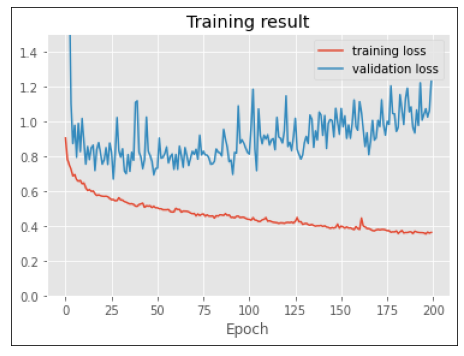

In [ ]:
if training:
  epochs = 200
  plt.style.use("ggplot")
  plt.figure()
  plt.ylim(top=1.5)
  plt.plot(np.arange(0, epochs), history.history["loss"], label="training loss")
  plt.plot(np.arange(0, epochs), history.history["val_loss"], label="validation loss")
  plt.title("Training result")
  plt.xlabel("Epoch")
  plt.legend(loc="upper right")
  plt.show()
    
else:
  fig, ax = plt.subplots(figsize= (8,8), subplot_kw={'xticks':[], 'yticks':[]})
  ax.imshow(io.imread("https://docs.google.com/uc?export=download&id=1xKYoshsnXVftSh7SJJirI9pvOHQOdsir"))

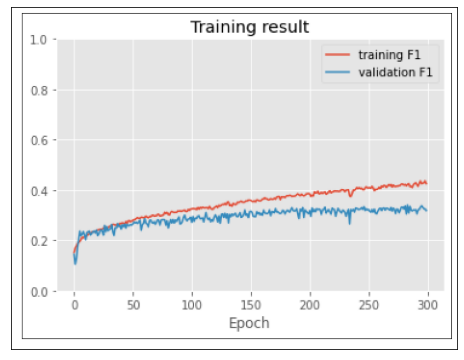

In [ ]:
if training:
  epochs = 200
  plt.style.use("ggplot")
  plt.figure()
  plt.ylim(top=1)
  plt.plot(np.arange(0, epochs), history.history["get_f1"], label="training F1")
  plt.plot(np.arange(0, epochs), history.history["val_get_f1"], label="validation F1")
  plt.title("Training result")
  plt.xlabel("Epoch")
  plt.legend(loc="upper right")
  plt.show()
else:
  fig, ax = plt.subplots(figsize= (8,8), subplot_kw={'xticks':[], 'yticks':[]})
  ax.imshow(io.imread("https://docs.google.com/uc?export=download&id=1ZyCoRfNdnYiHzfT9PZuDIWYdkA2X6O02"))

### Prediction on test set

We have already visualized the performance of our models in the previous subsection. Now it is time to test these models on the test set. Because we already monitored the F1 score on the test set during training, we already know what to expect. There is still one parameter that we can experiment with to change the outcome. Recall that the predicted output of the network consists of an array of float values. Each float value at a certain index is the probability that the class at that index is present or not. A threshold of 0.5 is generally used to classify a class as present (or just use argmax). However, we can play around with this threshold much like a hyper parameter in order to increase the precision or recall by respectively increasing or decreasing the threshold. Whether we value precision or recall more, depends on the weight of false positive and negatives. In the context of multilabel classification, we would rather want our network not to be overconfident in predicting classes in order to become the least amount of false positives. We can thus assume that we would rather have no predicted classes at all than have many wrong predictions. 

Aside from calculating the F1 score for each prediction and averaging it across all samples, we can also calculate it for each class independently. This will give us an idea of which class performs better or in other words which class the classifier was able to generalize well. 

In [ ]:
threshold = 0.5
print('\n-------- Metrics for VGG:---------\n ')

y_pred = model.predict(X_test)

y_pred[y_pred>=threshold] = 1
y_pred[y_pred<threshold] = 0

print('Precision: ', precision_score(y_test, y_pred, average='samples', zero_division=0)) 
print('Recall: ', recall_score(y_test, y_pred, average='samples')) 
print('F1-score: ', f1_score(y_test, y_pred, average='samples'), '\n') 

print('Per class F1 score: ')
f1_scores = f1_score(y_test, y_pred, average=None)
for i in range(len(f1_scores)):
  print(list(sorted(labels))[i], round(f1_scores[i],2))


-------- Metrics for VGG:---------
 
Precision:  0.2699083886769346
Recall:  0.6641114408176723
F1-score:  0.3613282036130701 

Per class F1 score: 
aeroplane 0.55
bicycle 0.22
bird 0.32
boat 0.29
bottle 0.21
bus 0.5
car 0.36
cat 0.5
chair 0.41
cow 0.18
diningtable 0.38
dog 0.35
horse 0.2
motorbike 0.26
person 0.53
pottedplant 0.32
sheep 0.24
sofa 0.36
train 0.47
tvmonitor 0.32


In order to see which threshold produces an optimal precision and recall, we can plot the performance at each threshold on a precision-recall curve. We can see that the optimal F1 score is obtained around the 0.5 threshold. We could increase the precision by lowering the threshold but the very small gain and large decrease in recall would not be worth it. 

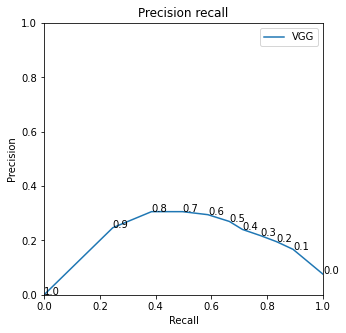

In [ ]:
fig, ax = plt.subplots(figsize= (5,5))
ax.set_title("Precision recall")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
ax.set_xlim(xmin=0, xmax=1)
ax.set_ylim(ymin=0, ymax=1)

x = []
y = []
for threshold in np.arange(0, 1.1, 0.1):
  y_pred = model.predict(X_test)
  y_pred[y_pred>=threshold] = 1
  y_pred[y_pred<threshold] = 0
  p = precision_score(y_test, y_pred, average='samples', zero_division=0)
  r = recall_score(y_test, y_pred, average='samples')
  ax.annotate(str(round(threshold,2)), (r, p))
  x.append(r)
  y.append(p)
  
ax.plot(x, y)
ax.lines[-1].set_label("VGG")

plt.legend(loc="upper right")
plt.show()

### Class Activation Maps

We can visualize the class activation maps from the trained model with the Global Average Pooling layer. This will help us visualize what our network is "looking" at when predicting its classes. The implementation is based on the following [codebase](https://github.com/alexisbcook/ResNetCAM-keras) for ResNet. We modified it to make it work for the VGG architecture. 

original


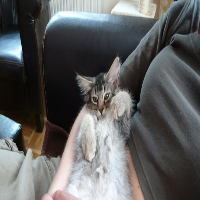

predicted class:  cat


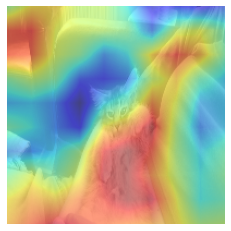

predicted class:  chair


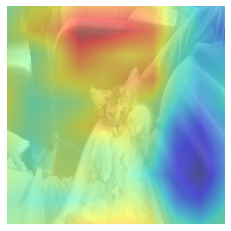

In [ ]:
dense_weights = model_cam.layers[-2].get_weights()[0]

# We define a new model that gives us two outputs
# The activation weights (tensor) from the batch normalized layer = 128, 10x10 maps
# And the predicted output vector of size 20
model_ = Model(inputs=model_cam.input, 
        outputs=(model_cam.layers[-4].output, model_cam.layers[-2].output))
print('original')
img = cv2.imread('Images/2009_003415.jpg')
img_or = cv2.resize(img, (200,200))
cv2_imshow(img_or)

#preprocess before predicting
img = np.expand_dims((np.array(cv2.resize(img, (64,64)))/255), axis=0)

activation_map, dense_output_vec = model_.predict(img)
dense_output_vec = dense_output_vec[0]
dense_output_vec[dense_output_vec >= 0.5] = 1

for i in range(20):
  #only show predicted class' CAM
  if (dense_output_vec[i] == 1):
    # shrink first dimension (1x10x10x128 -> 10x10x128)
    activation_map = np.squeeze(activation_map)
    #resize 10 x 10 maps into arbitrary larger size to fit original image
    amap = scipy.ndimage.zoom(activation_map, (20, 20, 1), order=1)
    # get the class weights for predicted class i 
    dense_class_weights = dense_weights[:, i]
    # multiply class weights and activation map to get final heatmap
    # (200*200, 128) x (128,1) -> (200 x 200) CAM image  
    class_activation_map = np.dot(amap.reshape((200*200, 128)), dense_class_weights).reshape(200,200)
    print('predicted class: ',class_dictionary[i])
    plt.axis('off')
    plt.imshow(img_or, alpha=0.5)
    plt.imshow(class_activation_map, cmap='jet', alpha=0.5)
    plt.show()


We can visualize certain areas of interest for the predicted classes. For example, a cat was predicted to be present with the bottom half and paws of the cat as highly activated points. While some of the areas of the heatmap make sense, some obviously do not. For example, a certain area of the chair shows high activations. It seems like a feature that was learned and thus associated with the class cat. This tells us that the network has not been trained well enough to correctly associate all the features of "cats" and picked up on arbitrary shapes and features as well. The model also predicts a chair. If we inspect which area the model based its decision on, it makes sense to why it would predict chair. One interesting note is that the chair was actually not labeled in the original labeling. This is an instance where our network learns features that are beyond human classification. So why wasn't a person predicted when there's obviously one holding the cat? With class activation maps, we can also visualize the areas of interest for classes that were not necessarily predicted in order to find out why the network was not confident enough to predict a supposed class.

Class activation maps do not only help us to visualize the areas of interest, but also the magnitude and confidence. We can quickly debug and reason about the shortcoming of the network without having to make assumptions purely based on the labeled predictions. It allows us to rationalize with the network and to understand its performance rather than to judge it purely on predictions. One conclusion that we can make for this particular network/prediction is that some under represented classes clearly need more training on more data such that the network would be able to generalize them well and be more confident about the particular shapes and patterns that occur for those specific classes. 

### Can we do better?

There are multiple techniques and approaches we could apply in order to obtain a better F1-score. 

- Binary classification:
Instead of training one model for this problem, we could train a binary classifier for each individual class. This could result into better class wise predictions depending on how well each classifier was trained. Since the images of our dataset are (intentionally) noisy, in that they also contains other classes rather than the one we are trying to predict, it becomes questionable how well the classifier will be able to learn. Another disadvantage of this approach is that instead of having one model, the amount of models grows with the number of classes. This can be problematic when we for example have 1000 classes.

- Label correlation: 
If we inspect the images in our dataset closely, we can see that some of the classes are usually present simultaneously, which makes sense. We can imagine that the images of vehicles usually contain people around or in them or that it would be likely that someone is sitting on a chair, instead of the chair being captured on its own. By exploiting this information, we can increase our confidence in other classes when we predict a certain class.

- Under / upsampling: 
We had already discussed this before. We can use resampling techniques in order to either balance or to increase the size of our dataset. It is known that deep neural networks are hungry for data. Our models might generalize better if we were somehow able to increase the amount of samples or increase the quality of existing samples without tampering the original class distribution or increase the risk of overfitting.

- State of the art architectures and techniques: 
There are various amounts of architectures that have been proposed specifically for multilabel classification that have reported very high performance. Unfortunately, implementing such architectures from scratch and/or manually adjusting them according to the given resources such as our dataset, requires thorough research, experimentation and most importantly, time. 

- Ensembles / super classifiers: 
Another approach that is known to have reported high performance in [Kaggle competitions](https://medium.com/kaggle-blog/planet-understanding-the-amazon-from-space-1st-place-winners-interview-bf66fb444bc2) is the use of ensembles or "super classifiers". In this approach multiple classifiers are trained on (or different portions of) the same dataset. Each classifier may be different from another in terms of architecture, trained epochs or difference in hyperparameters. During prediction, the collective output of the ensemble is combined (averaged or voted) in order to produce a more accurate result than if we were to classify with a single model. 

- Transfer learning: A commonly used technique that utilizes a pretrained network on the same or different dataset. We will discuss this approach in the next subsection.

## Transfer learning

We can conclude from the previous subsection that achieving a well performing multi-label classifier with a small amount of data is hard, if not impossible. Also, we discussed how we can potentially solve this by for example utilizing transfer learning. This approach is used to fine-tune a pretrained classifier in order to make it work well for a different problem. Some of the available pretrained models are deep networks that are trained on very large datasets. This means that the classifier already learned the features that were available for the dataset it was trained on. The last few layers of this pretrained network consist of hidden layers that contain the weights for a specific problem. We can replace these layers by new layers, freeze all the other pretrained layers and then retrain the network. We will essentially "recycle" the features that were trained on a very large dataset often with high performance, and utilize them for a new problem. In our case that's multi-label classification.

### Data

We will load the same multi-label data as before, this time with a different image shape. 

In [ ]:
X_train, y_train = collect_data(training_data, img_shape=(224,224))
X_val, y_val = collect_data(validation_data, img_shape=(224,224))
X_test, y_test = collect_data(testing_data, img_shape=(224,224))

# sanity check
print("Size training image set: ", len(X_train))
print("Size training label set: ",len(y_train))
print("Size validation image set: ",len(X_val))
print("Size validation label set: ",len(y_val))
print("Size test image set: ",len(X_test))
print("Size test label set: ",len(y_test))

Size training image set:  5013
Size training label set:  5013
Size validation image set:  1030
Size validation label set:  1030
Size test image set:  1011
Size test label set:  1011


We also normalize and shuffle the dataset however omitting standardization.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


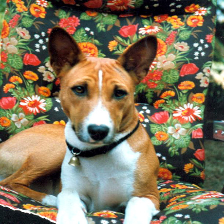

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


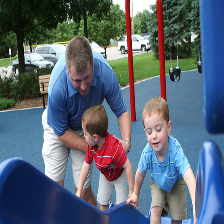

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_sets(X_train, y_train, X_val, y_val, X_test, y_test, standardize=False)

### Retrieving pretrained model

The model that we are going to finetune is [MobileNet](https://arxiv.org/pdf/1704.04861.pdf). This network was proposed as an efficient and versatile model that can thus be deployed for many different problems. As networks became deeper to increase accuracy, so did their computational latency. In order to solve this, MobileNet implemented a more efficient architecture. This will decrease the time it takes to train the network substantially. 

This pretrained MobileNet has been trained on the [ImageNet](http://image-net.org/about-stats) dataset. This dataset consists of millions of images and thousands of classes of images. By using this pretrained network we save ourselves the computational burden of training the network on an extremely large dataset.  

In the code section below, we download the pretrained model directly from its source. We exclude the top layer, meaning that we exclude the trained hidden layers. Since we are going to finetune this model, we will add our own. We then freeze all the layers. The reason we freeze them is because when finetuning the model, we do not want the layers of the original pretrained network to train. After doing so, we add our own custom layer ending with the final dense layers necessary for generating the multi-labels. We choose for the Adam optimizer although different optimizers may result into better performance. Both the activation layer remain as sigmoid and we define our loss function as binary crossentropy. Similarly for the metric, we use the F1 metric as before to calculate the performance of the network.

In [ ]:
from keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(20, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[get_f1])

9412608/9406464 [==============================] - 0s 0us/step


### Training/loading pretrained model

Below, we will train or load the network. During training, we will reuse the ImageDataGenerator to combat overfitting.

In [ ]:
# Set to true if you want to retrain the binary classifier
training = False

datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.2
                               ,height_shift_range=0.2, shear_range=0.2,zoom_range=0.2
                               ,fill_mode="nearest", horizontal_flip=True)
datagen.fit(X_train)


save_best = ModelCheckpoint('multilabel_tf.h5', monitor='val_get_f1', verbose=0, 
                              save_best_only=True, mode='max', period=1)

# training the binary classifier
if training == True:
  history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                          validation_data=(x_val, y_val),
                          epochs=3, verbose=1, workers=4, shuffle=True, callbacks=[save_best])
else:
  !wget -O multilabel_tf.h5 -nc https://drive.google.com/uc?id=1_1LaLSwhEQGntPrERbq5SzJEaSrqzqxG
  model = load_model('multilabel_tf.h5', custom_objects={
      'get_f1': get_f1,
  })

--2020-06-01 18:03:24--  https://drive.google.com/uc?id=1_1LaLSwhEQGntPrERbq5SzJEaSrqzqxG
Resolving drive.google.com (drive.google.com)... 172.217.203.113, 172.217.203.102, 172.217.203.138, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fj22mp1167qpc8q8kttp1d6mb65ibdtb/1591034550000/03077866314969851184/*/1_1LaLSwhEQGntPrERbq5SzJEaSrqzqxG [following]
--2020-06-01 18:03:25--  https://doc-0c-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fj22mp1167qpc8q8kttp1d6mb65ibdtb/1591034550000/03077866314969851184/*/1_1LaLSwhEQGntPrERbq5SzJEaSrqzqxG
Resolving doc-0c-5g-docs.googleusercontent.com (doc-0c-5g-docs.googleusercontent.com)... 64.233.170.132, 2607:f8b0:400c:c0d::84
Connecting to doc-0c-5g-docs.googleusercontent.com (doc-0c-5g-docs.googleusercontent.com)|64

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### Plotting performance

We can already conclude that the network needs less epochs to converge and achieves higher performance compared to the previous approach of training from scratch. We could have potentially trained the network for a longer period to achieve more performance but for the purpose of demonstration this was not necessary. 

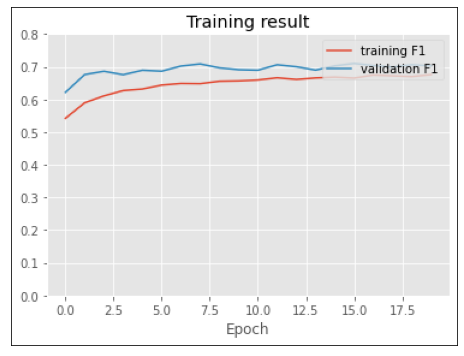

In [ ]:
fig, ax = plt.subplots(figsize= (8,8), subplot_kw={'xticks':[], 'yticks':[]})
ax.imshow(io.imread("https://docs.google.com/uc?export=download&id=1NtqviORI4A-no78IOYt03FVGbSK1h62M"))

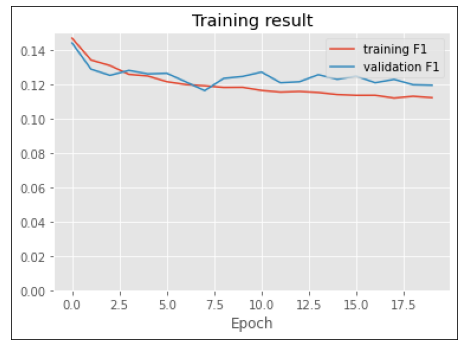

In [ ]:
fig, ax = plt.subplots(figsize= (8,8), subplot_kw={'xticks':[], 'yticks':[]})
ax.imshow(io.imread("https://docs.google.com/uc?export=download&id=1_bObHLO1Fongutg466qNFldZo9r3K0sE"))

### Prediction on test set 

In order to solidify our observations, we can take a look at how the network performs on the test set. We again observe that we achieve high recall and also high performance. This amounts to a relatively high F1 score. By looking at the class level predictions, we can see that some classes are trained significantly better than others. If time was on our side, we could train the network for longer and observe whether the class level predictions improve. If not, we may have to experiment with different pretrained models that may be more suited for the problem or experiment with the custom hidden layers.  

In [ ]:
threshold = 0.5
print('\n-------- Metrics for MobileNetV2:---------\n ')

y_pred = model.predict(X_test)

y_pred[y_pred>=threshold] = 1
y_pred[y_pred<threshold] = 0

print('Precision: ', precision_score(y_test, y_pred, average='samples', zero_division=0)) 
print('Recall: ', recall_score(y_test, y_pred, average='samples')) 
print('F1-score: ', f1_score(y_test, y_pred, average='samples'), '\n') 

print('Per class F1 score: ')
f1_scores = f1_score(y_test, y_pred, average=None)
for i in range(len(f1_scores)):
  print(list(sorted(labels))[i], round(f1_scores[i],2))


-------- Metrics for MobileNetV2:---------
 
Precision:  0.7287998681173755
Recall:  0.7295911638641609
F1-score:  0.7021007018039659 

Per class F1 score: 
aeroplane 0.87
bicycle 0.81
bird 0.89
boat 0.76
bottle 0.47
bus 0.89
car 0.62
cat 0.88
chair 0.71
cow 0.6
diningtable 0.71
dog 0.57
horse 0.74
motorbike 0.78
person 0.69
pottedplant 0.39
sheep 0.77
sofa 0.56
train 0.87
tvmonitor 0.73


# 4 Adversial examples

In this section we will try to fool a classifier using adversarial examples. We will train a binary classifier for this purpose rather than try to fool the multilabel classifier trained in previous sections. It will be much easier to verify whether we've been able to fool the classifier this way. We will train an adversary model to fool this classifier by adding perturbations to its input. If the adversary was succesful, then the model will falsely predict a label that was not present in the image. Ofcourse, we must take into account whether the classifier was actually fooled or whether it was an error made by the classifier. 

In [ ]:
from keras.models import Model, load_model,Sequential
from keras.applications import MobileNetV2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dropout, Lambda

## Data

To perform binary classifier, only the dataset containing label aeroplane and label bicycle are considered. All images are resized to 96*96. Note that dataset is shuffled and normalized as the same as previous section in classification task. The dataset consists of training set (500), validation set (121), test set (134).

### Functions for loading and preprocessing

In [ ]:
def load_image(path):
  try:
    url = os.path.join("Images",path + ".jpg")
    img = cv2.imread(url)
    img = cv2.resize(img, (96,96)) # resize
    img = img[...,::-1] # BGR -> RGB
    return img
  except:
    print()
  
def get_data(file_name):
  images = []
  labels = []

  with open(os.path.join("Classification",file_name)) as file:
    lines = file.readlines()
    for line in lines:
      im_path, label = line.split(" ")
      # we skip lines if its label does not make sense
      if label != '\n':
        if '\n' in label:
          if (label.strip() == 'aeroplane' or label.strip() == 'bicycle'):
            label = label[0:len(label)-1]
            tag = 0
            if (label == 'aeroplane'):
              tag = 1
            labels.append(tag)
            images.append(load_image(im_path))
  return images, labels

#shuffle
def preprocess_sets(X_train, y_train, X_val, y_val, X_test, y_test, standardize=True):

  random.Random(42).shuffle(X_train)
  random.Random(42).shuffle(y_train)

  print(y_train[0])
  cv2_imshow(cv2.cvtColor(X_train[0], cv2.COLOR_RGB2BGR))
  print(y_train[8])
  cv2_imshow(cv2.cvtColor(X_train[8], cv2.COLOR_RGB2BGR))

  #normalization
  X_train = np.array(X_train, dtype="float") / 255.0
  X_test = np.array(X_test, dtype="float") / 255.0
  X_val = np.array(X_val, dtype="float") / 255.0

  #standardization
  if (standardize):
    X_train_mean = np.mean(X_train, axis=0)
    X_train -= X_train_mean
    X_test -= X_train_mean
    X_val -= X_train_mean

  y_train = np.array(y_train)
  y_test = np.array(y_test)
  y_val = np.array(y_val)

  return X_train, y_train, X_val, y_val, X_test, y_test


### Load and preprocess dataset

1


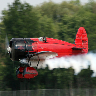

0


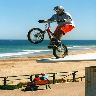

In [ ]:
X_train, y_train = get_data("labels_train.txt")
X_test, y_test = get_data("labels_test.txt")
X_val, y_val = get_data("labels_validation.txt")
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_sets(X_train, y_train, X_val, y_val, X_test, y_test, standardize=False)

In [ ]:
# sanity check
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(500, 96, 96, 3)
(121, 96, 96, 3)
(134, 96, 96, 3)
(500,)
(121,)
(134,)


## Binary classifier

The binary classifier should have a high accuracy and can classify bicycle and aeroplane correctly. This is important in further generating adversial examples.

### Train binary classifier

A binary classifier is trained by transfer learning based on the pretrained model *MobileNetV2*. Note that MobileNetV2 was already introduced in the transfer learning of previous multilabel classification task.

In [ ]:
from keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(96,96,3), include_top=False, weights='imagenet')
base_model.trainable = False
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
from keras.models import load_model
 

# Set to true if you want to retrain the binary classifier
training = False

datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.2
                               ,height_shift_range=0.2, shear_range=0.2,zoom_range=0.2
                               ,fill_mode="nearest", horizontal_flip=True)
datagen.fit(X_train)


save_best = ModelCheckpoint('binary_tf.h5', monitor='accuracy', verbose=0, 
                              save_best_only=True, mode='max', period=1)

# training the binary classifier
if training == True:
  history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                          validation_data=(x_val, y_val),
                          epochs=20, verbose=1, workers=4, shuffle=True, callbacks=[save_best])
else:
  !wget -O binary_tf.h5 -nc https://drive.google.com/uc?id=1XTfMiyR_AKna6oXbePNda9nbDWj2c9Y0
  model = load_model('binary_tf.h5')

--2020-06-01 18:18:27--  https://drive.google.com/uc?id=1XTfMiyR_AKna6oXbePNda9nbDWj2c9Y0
Resolving drive.google.com (drive.google.com)... 172.217.203.139, 172.217.203.113, 172.217.203.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hto5inll9osn7f8age42si9f77d60ss9/1591035450000/03077866314969851184/*/1XTfMiyR_AKna6oXbePNda9nbDWj2c9Y0 [following]
--2020-06-01 18:18:28--  https://doc-08-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hto5inll9osn7f8age42si9f77d60ss9/1591035450000/03077866314969851184/*/1XTfMiyR_AKna6oXbePNda9nbDWj2c9Y0
Resolving doc-08-5g-docs.googleusercontent.com (doc-08-5g-docs.googleusercontent.com)... 64.233.170.132, 2607:f8b0:400c:c0d::84
Connecting to doc-08-5g-docs.googleusercontent.com (doc-08-5g-docs.googleusercontent.com)|64

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


The model is trained on batch size = 32, epochs = 20. Final model at epoch = 20 has an accuracy of 0.9000 on the training set, 0.9254 on the validation set and 0.8842 on the test set.

In [ ]:
# Train set
binary_train = model.predict(X_train)

# Test set
binary_test = model.predict(X_test)
[score,acc] = model.evaluate(X_test, y_test)
print(acc)

121/121 [==============================] - 1s 11ms/step
0.8842975497245789


## Decept truth label

The lables of original images are flipped, i.e., aeroplane is labeled with 0, while bicycle is labled with 1. Note that the labels of dataset for training the binary classifier obove are 1 for aeroplane and 0 for bicycle.

In [ ]:
# generate deceptive labels
# by flipping truth boolean 
def deceptive(y_data):
  y_dec = []
  for i, y in enumerate(y_data):
    if (y == 1):
      y = 0
    else:
      y = 1
    y_dec.append(y)
    
  y_dec = np.array(y_dec)
  return y_dec

In [ ]:
y_train_dec = deceptive(y_train)
y_test_dec = deceptive(y_test)
print("Original lables:")
print("Aeroplane:", y_train[0])
print("Bicycle:", y_train[8])
print("Deceptive lables")
print("Aeroplane:", y_train_dec[0])
print("Bicycle:", y_train_dec[8])

Original lables:
Aeroplane: 1
Bicycle: 0
Deceptive lables
Aeroplane: 0
Bicycle: 1


## Define adversarial network

![adversary](https://drive.google.com/uc?id=1jx7hmHNu0i19IP0F1-8ZVFZW1Rj4njsf)

To construct the adversarial network, the convolutional autoencoder is used to generate perturbation. After adding perturbation to original image, the adversarial image is generated. Feeding the adversarial image into the binary classifier, we want the adversarial image with deceptive label can fool the binary classifier. By minizing the loss function between predicted label and deceptive label, the adversarial image is expected to be classified as the decptive label.

1. To prevent the perturbation too large, perturbatioon is scaled to have a fixed norm. That is, we multiply perturbation by min(1, e/L2). e is the maximum permissible L2 norm , L2 is the L2 norm of perturbation. Thus, the larger the e, the larger the maximum permissible perturbation, the smaller the the constriant in perturbation.  

2. Binary classifier is frozen.

### Model architecture

1. Convolutional autoencoder:
  encoder: 3 convolution layers; decoder: 3 convolution layers

In [ ]:
# network parameters
input_shape = (96,96,3)

input_img = Input(shape=input_shape)
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

2. Scaling perturbation, add perturbation to original image, clip adversarial image
3. Binary classifier

In [ ]:
# Scaling: maximum permissible L2 norm is 200
def scale(args):
  decoded,input_img = args
  a = K.minimum(K.pow(K.sqrt(K.sum(K.square(decoded))),-1)*200,1) 
  return decoded*a

# Add perturbation
def addpert(args):
  perturbation,input_img = args
  b = K.clip(perturbation+input_img,0,1)
  return b

perturbation = Lambda(scale, output_shape=input_shape, name='scale')([decoded,input_img])
fakeimage = Lambda(addpert, output_shape=input_shape, name='fakeimage')([perturbation,input_img])

# Use classifier from previous section
outputs = model(fakeimage)

## Train adversary on training set

### e = 200, epoch = 20

In [ ]:
batch_size=32
training = False

adversarial_200 = Model(input_img, outputs, name='adversial')
adversarial_200.layers[30].trainable = False # make classifier weight freeze
adversarial_200.compile(optimizer='adam',loss='binary_crossentropy', metrics = ['accuracy'])

if training:
  history_200 = adversarial_200.fit(X_train, y_train_dec,
          batch_size=batch_size,
          epochs=20,
          verbose=1)
  
  #https://github.com/keras-team/keras/issues/13279
  def freeze_layers(model):
    for i in model.layers:
        i.trainable = False
        if isinstance(i, Model):
            freeze_layers(i)
    return model

  model_freezed = freeze_layers(adversarial_200)
  model_freezed.save('adversarial_train_200.h5')
else:
  !wget -O adversarial_train_200.h5 -nc https://drive.google.com/uc?id=1aF0KQb-RGDAy7h_3ZZacvAKTD-G2upGi
  adversarial_200 = load_model("adversarial_train_200.h5")

--2020-06-01 18:19:20--  https://drive.google.com/uc?id=1aF0KQb-RGDAy7h_3ZZacvAKTD-G2upGi
Resolving drive.google.com (drive.google.com)... 172.217.204.101, 172.217.204.102, 172.217.204.113, ...
Connecting to drive.google.com (drive.google.com)|172.217.204.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/thdct6e71t6b8usl3nun2vpcrvmcs1a4/1591035525000/03077866314969851184/*/1aF0KQb-RGDAy7h_3ZZacvAKTD-G2upGi [following]
--2020-06-01 18:19:21--  https://doc-10-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/thdct6e71t6b8usl3nun2vpcrvmcs1a4/1591035525000/03077866314969851184/*/1aF0KQb-RGDAy7h_3ZZacvAKTD-G2upGi
Resolving doc-10-5g-docs.googleusercontent.com (doc-10-5g-docs.googleusercontent.com)... 64.233.170.132, 2607:f8b0:400c:c0d::84
Connecting to doc-10-5g-docs.googleusercontent.com (doc-10-5g-docs.googleusercontent.com)|64

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


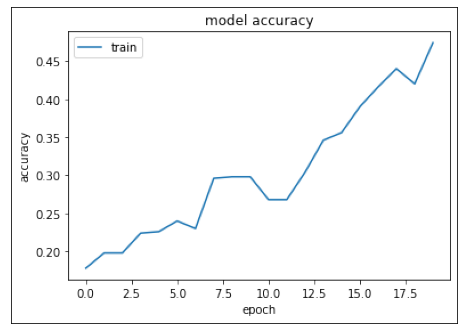

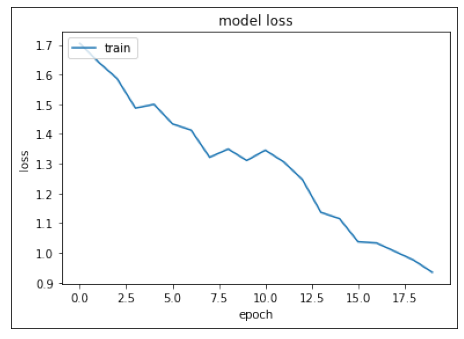

In [ ]:
if training:
  # summarize history for accuracy
  plt.plot(history_200.history['accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history_200.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train'], loc='upper left')
  plt.show()
else:
  fig, ax = plt.subplots(figsize= (8,8), subplot_kw={'xticks':[], 'yticks':[]})
  ax.imshow(io.imread("https://docs.google.com/uc?export=download&id=14rkZCpjowea-9i_CDDfuUKWKqFPFnJR6"))

  fig, ax = plt.subplots(figsize= (8,8), subplot_kw={'xticks':[], 'yticks':[]})
  ax.imshow(io.imread("https://docs.google.com/uc?export=download&id=1SwPKqCZlNSgZB64WPJpG-2VOzylOlWTE"))

In [ ]:
def show_original_decepted(orig, dec, y_orig,y_dec, y_predict,pred_binary,num=10):
  plt.figure(figsize=(20,5))
  next_ = 1
  for i in range(len(y_orig)):
    if next_ == num:
      break
    if int(np.round(y_predict[i])) == y_dec[i]:
      # display original
      ax = plt.subplot(2, num, next_+1)
      plt.imshow(orig[i].reshape(96, 96, 3))
      ax.set_title(
                  "Fooled @" + str(i) 
                )
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display fake image
      ax = plt.subplot(2, num, next_ +1 + num)
      plt.imshow(dec[i].reshape(96, 96, 3))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      next_+=1
    else:
      continue        
  plt.show()

Following is the visualization of perturbed images and perturbations versus original images. Only images fooled under attack are displayed.

**Perturbed images**

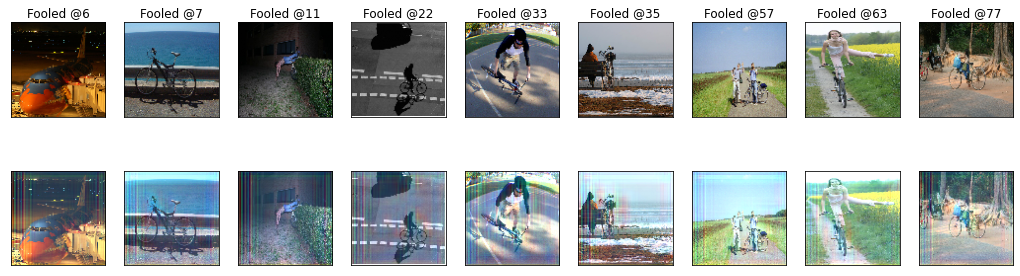

In [ ]:
adversial_model = adversarial_200
layer_name = 'fakeimage'
intermediate_layer_model = Model(inputs=adversial_model.input,outputs=adversial_model.get_layer(layer_name).output)
image_gen = intermediate_layer_model.predict(X_train)
output = adversial_model.predict(X_train)
show_original_decepted(X_train, image_gen,y_train,y_train_dec,output,binary_train,10)

**Perturbation**

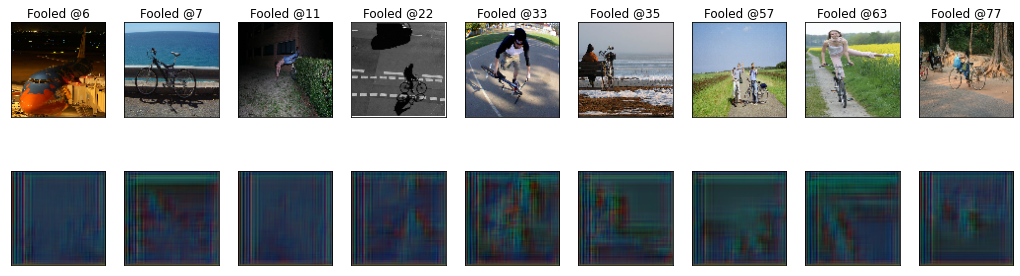

In [ ]:
adversial_model = adversarial_200
layer_name = 'scale'
intermediate_layer_model = Model(inputs=adversial_model.input,outputs=adversial_model.get_layer(layer_name).output)
pertur = intermediate_layer_model.predict(X_train)
show_original_decepted(X_train, pertur,y_train,y_train_dec,output,binary_train,10)

Images are recognizable. Around 50\% images are fooled by the attacker. Bicycle are easier to be fooled under the attack than aeroplane.

### e = 800, epoch = 20

In [ ]:
# network parameters
input_shape = (96,96,3)

input_img = Input(shape=input_shape)
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [ ]:
# Scaling: maximum permissible L2 norm is 200
def scale(args):
  decoded,input_img = args
  a = K.minimum(K.pow(K.sqrt(K.sum(K.square(decoded))),-1)*800,1) 
  return decoded*a

# Add perturbation
def addpert(args):
  perturbation,input_img = args
  b = K.clip(perturbation+input_img,0,1)
  return b

perturbation = Lambda(scale, output_shape=input_shape, name='scale')([decoded,input_img])
fakeimage = Lambda(addpert, output_shape=input_shape, name='fakeimage')([perturbation,input_img])

# Use classifier from previous section
outputs = model(fakeimage)

adversarial_800 = Model(input_img, outputs, name='adversial')
adversarial_800.layers[30].trainable = False # make classifier weight freeze
adversarial_800.compile(optimizer='adam',loss='binary_crossentropy', metrics = ['accuracy'])

In [ ]:
training = False

if training:
  history_800 = adversarial_800.fit(X_train, y_train_dec,
          batch_size=batch_size,
          epochs=20,
          verbose=1)
  
  #https://github.com/keras-team/keras/issues/13279
  def freeze_layers(model):
    for i in model.layers:
        i.trainable = False
        if isinstance(i, Model):
            freeze_layers(i)
    return model

  model_freezed = freeze_layers(adversarial_800)
  model_freezed.save('adversarial_train_800.h5')
else:
  !wget -O adversarial_train_800.h5 -nc https://drive.google.com/uc?id=1mZ3ZJ25BSxV3BXFIna7MY0a0Z9wSKIPL
  adversarial_800 = load_model("adversarial_train_800.h5")

--2020-06-01 18:19:58--  https://drive.google.com/uc?id=1mZ3ZJ25BSxV3BXFIna7MY0a0Z9wSKIPL
Resolving drive.google.com (drive.google.com)... 172.217.203.139, 172.217.203.113, 172.217.203.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sptn4pqsq98d0muq5o0sf8sbmoq06spg/1591035525000/03077866314969851184/*/1mZ3ZJ25BSxV3BXFIna7MY0a0Z9wSKIPL [following]
--2020-06-01 18:19:59--  https://doc-10-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sptn4pqsq98d0muq5o0sf8sbmoq06spg/1591035525000/03077866314969851184/*/1mZ3ZJ25BSxV3BXFIna7MY0a0Z9wSKIPL
Resolving doc-10-5g-docs.googleusercontent.com (doc-10-5g-docs.googleusercontent.com)... 64.233.170.132, 2607:f8b0:400c:c0d::84
Connecting to doc-10-5g-docs.googleusercontent.com (doc-10-5g-docs.googleusercontent.com)|64

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


**Perturbed images**

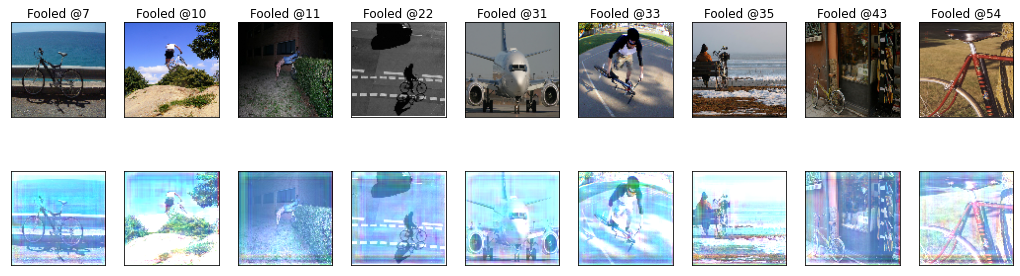

In [ ]:
adversial_model = adversarial_800
layer_name = 'fakeimage'
intermediate_layer_model = Model(inputs=adversial_model.input,outputs=adversial_model.get_layer(layer_name).output)
image_gen = intermediate_layer_model.predict(X_train)
output = adversial_model.predict(X_train)
show_original_decepted(X_train, image_gen,y_train,y_train_dec,output,binary_train,10)

**Perturbation**

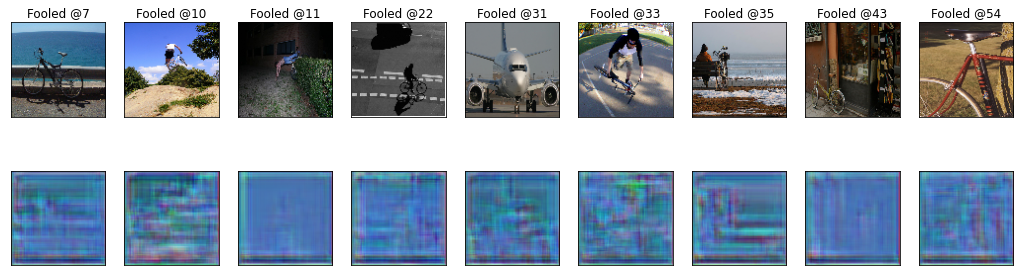

In [ ]:
adversial_model = adversarial_800
layer_name = 'scale'
intermediate_layer_model = Model(inputs=adversial_model.input,outputs=adversial_model.get_layer(layer_name).output)
pertur = intermediate_layer_model.predict(X_train)
show_original_decepted(X_train, pertur,y_train,y_train_dec,output,binary_train,10)

More perturbations are added to the image. Images are not as recognizable as before with e = 200. But more images (around 60\%) are fooled by the attacker.

## Comparing result on test set

### e = 200, epoch = 20

In [ ]:
# network parameters
input_shape = (96,96,3)

input_img = Input(shape=input_shape)
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [ ]:
# Scaling: maximum permissible L2 norm is 200
def scale(args):
  decoded,input_img = args
  a = K.minimum(K.pow(K.sqrt(K.sum(K.square(decoded))),-1)*200,1) 
  return decoded*a

# Add perturbation
def addpert(args):
  perturbation,input_img = args
  b = K.clip(perturbation+input_img,0,1)
  return b

perturbation = Lambda(scale, output_shape=input_shape, name='scale')([decoded,input_img])
fakeimage = Lambda(addpert, output_shape=input_shape, name='fakeimage')([perturbation,input_img])

# Use classifier from previous section
outputs = model(fakeimage)

adversarial_200_test = Model(input_img, outputs, name='adversial')
adversarial_200_test.layers[30].trainable = False # make classifier weight freeze
adversarial_200_test.compile(optimizer='adam',loss='binary_crossentropy', metrics = ['accuracy'])

In [ ]:
batch_size = 32
training = False

if training:
  history_200_test = adversarial_200_test.fit(X_test, y_test_dec,
          batch_size=batch_size,
          epochs=20,
          verbose=1)

  #https://github.com/keras-team/keras/issues/13279
  def freeze_layers(model):
    for i in model.layers:
        i.trainable = False
        if isinstance(i, Model):
            freeze_layers(i)
    return model

  model_freezed = freeze_layers(adversarial_200_test)
  model_freezed.save('adversarial_test_200.h5')
else:
  !wget -O adversarial_test_200.h5 -nc https://drive.google.com/uc?id=1oSpHXDNPXb5btAv13c1ATLbUy-C3AKjS
  adversarial_test_200 = load_model("adversarial_test_200.h5")

--2020-06-01 18:20:34--  https://drive.google.com/uc?id=1oSpHXDNPXb5btAv13c1ATLbUy-C3AKjS
Resolving drive.google.com (drive.google.com)... 172.217.204.101, 172.217.204.102, 172.217.204.113, ...
Connecting to drive.google.com (drive.google.com)|172.217.204.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9b151fh18is9mrrtu4qn89non0d6qo93/1591035600000/03077866314969851184/*/1oSpHXDNPXb5btAv13c1ATLbUy-C3AKjS [following]
--2020-06-01 18:20:35--  https://doc-0s-5g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9b151fh18is9mrrtu4qn89non0d6qo93/1591035600000/03077866314969851184/*/1oSpHXDNPXb5btAv13c1ATLbUy-C3AKjS
Resolving doc-0s-5g-docs.googleusercontent.com (doc-0s-5g-docs.googleusercontent.com)... 64.233.170.132, 2607:f8b0:400c:c0d::84
Connecting to doc-0s-5g-docs.googleusercontent.com (doc-0s-5g-docs.googleusercontent.com)|64

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


**Perturbed images**

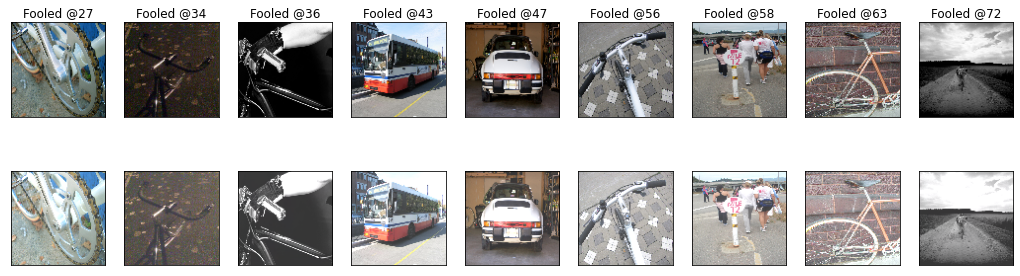

In [ ]:
adversial_model = adversarial_200_test
layer_name = 'fakeimage'
intermediate_layer_model = Model(inputs=adversial_model.input,outputs=adversial_model.get_layer(layer_name).output)
image_gen = intermediate_layer_model.predict(X_test)
output = adversial_model.predict(X_test)
show_original_decepted(X_test, image_gen,y_test,y_test_dec,output,binary_test,10)

**Perturbation**

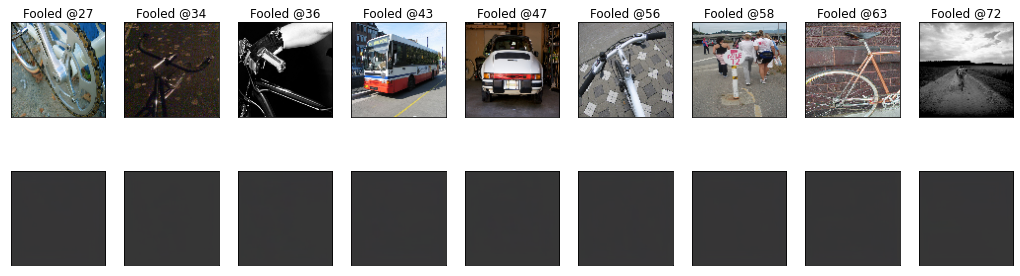

In [ ]:
adversial_model = adversarial_200_test
layer_name = 'scale'
intermediate_layer_model = Model(inputs=adversial_model.input,outputs=adversial_model.get_layer(layer_name).output)
pertur = intermediate_layer_model.predict(X_test)
output = adversial_model.predict(X_test)
show_original_decepted(X_test, pertur,y_test,y_test_dec,output,binary_test,10)

Compared to the train set, images on the test set need less perturbation to fool the system.

# 6 discussion

## Multilabel classification
In the third section we have dived into the problem of multilabel classification. We have analyzed the PASCAL VOC-2009. It became obvious that training any deep learning architecture with the abundance (and imbalance) of data would be a challenge. We took on these challenges and achieved a rather dissapointing performance. Although the classifier was able to recall most of the labels in its prediction, it was lacking a lot of precision. One of the possible improvements was to experiment with transfer learning. This improved our F1 score and resulted a more robust multi-label classifier. By utilizing a pretrained network, we were relieved of the burden of learning actual features that might occur in not only our dataset, but other new images as well. Instead, we reused pretrained features to train our own custom network to learn recognize abstract concepts (our classes). By using MobileNet, we also were able to converge faster to an optimum. We saved ourselves a lot of time and headache by utilizing both pretrained models and state-of-the-art models that are proposed as being efficient and versatile. It goes without saying that there are many more alternatives as we discussed before. If time was on our side, we would definitely want to explore these and exploit them to achieve a more robust and higher performing multi-label classifier. 

## Adversarial examples

In the final section, we explore the adversarial examples. The binary classifier is attacked by the generated images, which is the addition of noise to the original image. Noise is generated by using a convolutional autoencoder. In this task, we explore the following aspects.

1. The effect of different amount of noise on the attack.
2. The difference between train set and test set on the attack.

Firstly, noise generated by autoencoder can be controlled by the maximum permissible l2 norm of perturbation (e). In the experiment of different e, we observe that attacker is more easily to fool the system as the increasing of e (less constraint on perturbation). In addidtion, the attacker can fool the system as the increasing of training epochs. If the l2 norm of noise is larger, the generated images are more likely less recognizable. Thus, the problem comes to find the balance between the amount of perturbation and the attack. This balance is explored by looking the generated images and the accuracy of system (binary classifier) on the dataset with decptive label. We want to increase the accuracy of binary classifier on the decptive lable as large as possible but at the same time the generated images should be recognizable.

Secondly, the comparision between two adversaries trained on the train set and on the test set. Note that the train set is used to train the binary classifier and test set is used to evaluate it. By comparing the perturbation, we observe that test set needs less perturbation to fool the system. The reason might be that the performance of binary classifier on the test set is slightly worse than that on the train set (0.02 difference in accuracy). Thus, less perturbation is enough for fooling the system on the test set. In addition, on both sets, it is observed that it easier to fool the system regarding the images with label "bicycle", whereas more perturbation needed to fool the images with label "aeroplane".

To evaluate the performance of adversary, the adversary is successful in the training parameters set of e = 200, epoch = 20. The images are recognisable for a human observer. Around 50% of images are classified correctly as the deceptive labels. It indicates that the binary classifier is not robust. In order to increase the robustness of the binary classifier under the attack, we can include the generated adversarial examples into the trainning set and train the binary classifier based on that training set.